In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from hdpgpc.get_data import compute_estimators_LDS
import math
from scipy.fft import fft
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import importlib
import pickle
import hdpgpc.GPI_HDP as hdpgp
import re
from datetime import datetime, timedelta
import time

/home/adrian.perez/Documents/OceanWave/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from hdpgpc.util_plots import print_results
import hdpgpc.util_plots as up
importlib.reload(up)

<module 'hdpgpc.util_plots' from '/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/util_plots.py'>

---

### 1. Lectura de datos

In [3]:
cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(os.path.join(cwd, 'data'), 'ocean')
data = np.load(os.path.join(data_path, 'VES3_2.npy'))[:,:,np.newaxis]
freq = np.load(os.path.join(data_path, 'freq_2.npy'))

print("Shape of the data: ")
print(data.shape)
num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(14376, 170, 1)


Shape of hs: (14376, 1)
How much spectra falls in the range 0.5-1.5 Hs: 3379


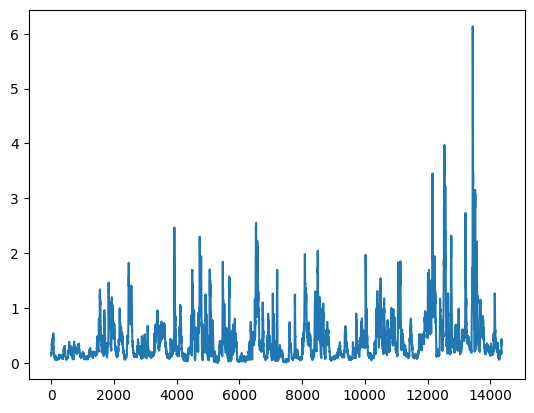

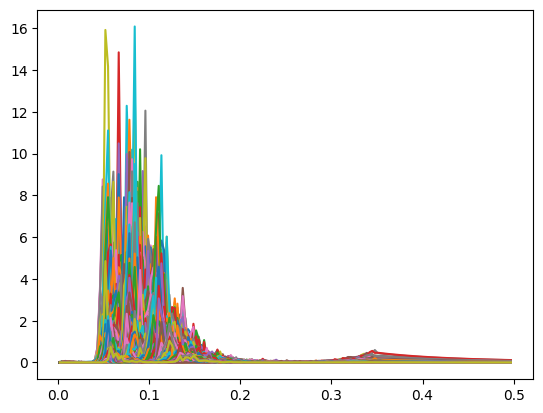

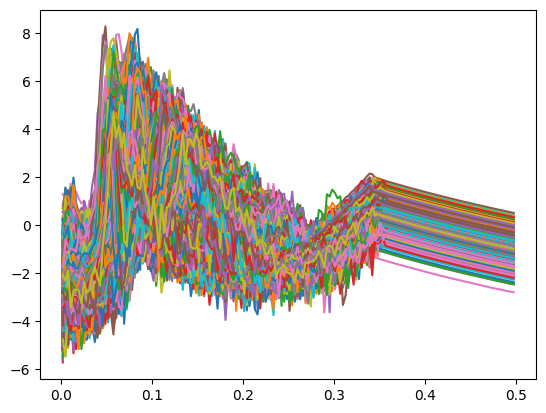

In [4]:
#Here we are going to compute the Heighs and try to filter following Hamiltons rule.
interv = np.repeat(freq[1]-freq[0], num_obs_per_sample)[:, np.newaxis]
hs = 4 * np.sqrt(data[:,:,0] @ interv)
print("Shape of hs: "+str(hs.shape))
plt.plot(hs)
chosen_indexes = np.where((hs > 0.5) & (hs < 1.5))[0]
print("How much spectra falls in the range 0.5-1.5 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq, data[:,:,0][chosen_indexes].T)
plt.show()
lognorm_data = np.log(data + 1e-6) - np.mean(np.log(data+ 1e-6), axis=1)[:,np.newaxis,:]
plt.plot(freq, lognorm_data[:,:,0][chosen_indexes].T)
plt.show()


### Se cogen solo los datos de un año natural

In [5]:
# # Fechas de inicio y finalización
# start_date = datetime(2019, 6, 25)
# end_date = datetime(2021, 2, 12)
#
# # Lista para guardar las fechas en formato cadena
# dates = []
#
# # Generar fechas y horas
# current_date = start_date
# while current_date <= end_date:
#     for hour in range(24):  # 24 horas por día
#         formatted_date = current_date.replace(hour=hour).strftime("%Y-%m-%d")
#         dates.append(formatted_date)
#     current_date += timedelta(days=1)
#
# data_2 = data.reshape(num_samples, num_obs_per_sample)
# data_2 = pd.DataFrame(data_2)
# data_2['fecha'] = dates
#
# data_2['fecha'] = pd.to_datetime(data_2['fecha'])
#
# data = data_2[data_2['fecha'].dt.year == 2020]
# data = data.drop(columns='fecha')
# data = data.to_numpy()
# data = data[:, :, np.newaxis]

In [6]:
#Select indexes
data = data[chosen_indexes]
print("Shape of the data: ")
print(data.shape)

num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(3379, 170, 1)


(170,)


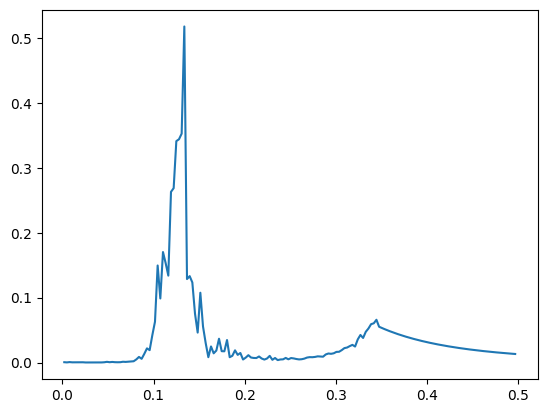

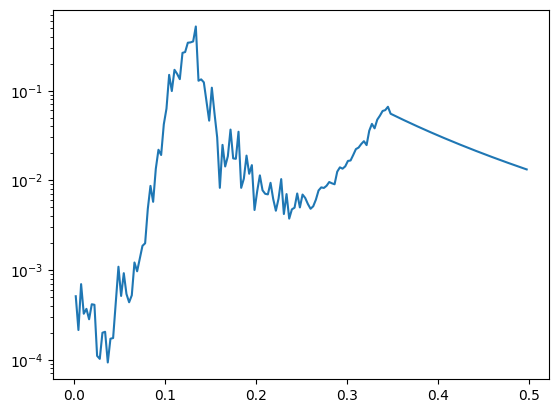

In [7]:
print(freq.shape)
plt.plot(freq, data[0,:,0])
plt.show()
plt.figure()
plt.plot(freq, data[0,:,0] + 1e-6)
plt.yscale('log')
plt.show()

In [8]:
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data, n_f=50)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.5
std_dif = std_dif * 0.1
bound_sigma = (std * 1e-7, std * 1e-6)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-8)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

Sigma estimated: 0.04984611537816366
Gamma estimated: 0.04984611537816366
Final sigma: 0.02492305768908183
Final gamma: 0.0004984611537816367
Final sigma bound: (2.4923057689081832e-09, 2.492305768908183e-08)
Final gamma bound: (4.984611537816367e-13, 4.984611537816367e-12)


In [9]:
M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M

In [10]:
outputscale_ = 0.1
ini_lengthscale = 1e-3
bound_lengthscale = (1e-7, 5e-3)

In [11]:
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
x_basis = np.atleast_2d(freq[0:100]).T
x_train = np.atleast_2d(freq[0:100]).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False

(100, 1)


In [12]:
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq[0], freq[-1], freq.shape[0]/2.0, dtype=np.float64)).T

In [13]:
sw_gp = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=True, max_models=100, inducing_points=inducing_points, estimation_limit=30)

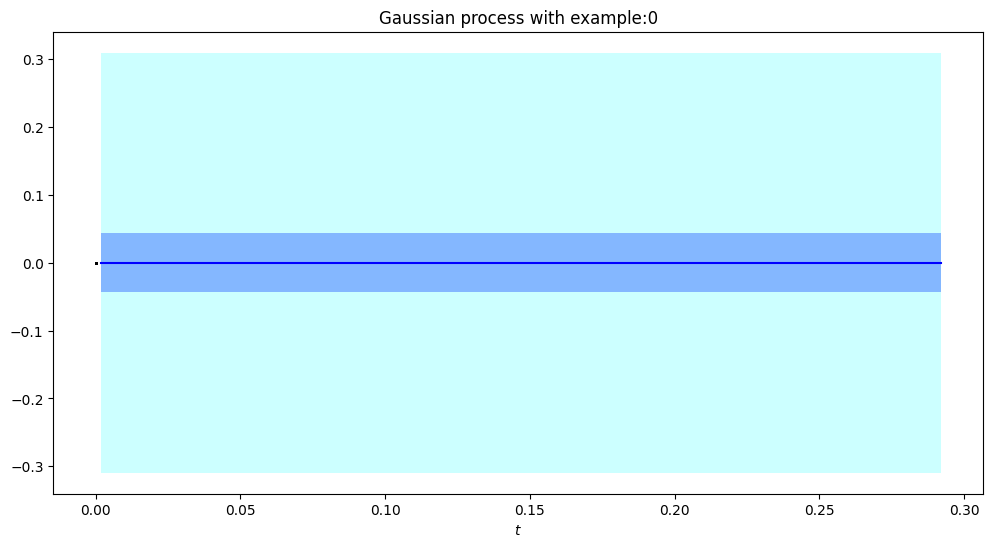

In [14]:
sw_gp.gpmodels[0][0].plot_last(0)

In [15]:
data_ = data[:,0:100,[0]]
sw_gp.include_sample(x_train, data_[0], with_warp=warp)

Main model chosen: 1

 Fitting_GP: 

Iter 1/4000 - Loss: 190576.410
Iter 501/4000 - Loss: 1.050
Iter 1001/4000 - Loss: 1.027
Iter 1501/4000 - Loss: 0.992
Iter 2001/4000 - Loss: 0.938
Iter 2501/4000 - Loss: 0.855
Iter 3001/4000 - Loss: 0.726
Iter 3501/4000 - Loss: 0.525


Parameter name: likelihood.noise_covar.raw_noise           value = [2.61656112]
Parameter name: mean_module.raw_constant                   value = 0.04061993251609472
Parameter name: covar_module.raw_outputscale               value = 2.667134369490005
Parameter name: covar_module.base_kernel.raw_lengthscale   value = [[-5.4132673]]
---Kernel estimated---
1.65**2 * RBF(length_scale=0.00445) + WhiteKernel(noise_level=2.34e-08)


In [16]:
from hdpgpc.util_plots import print_results
import hdpgpc.util_plots as up
importlib.reload(up)

<module 'hdpgpc.util_plots' from '/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/util_plots.py'>

Kernel estimated: 1.65**2 * RBF(length_scale=0.00445) + WhiteKernel(noise_level=2.34e-08)
Model 1 : MainModel: N : [N-1]
Model 2  : []
Classification error:  0.0 / 1 -- 0.0


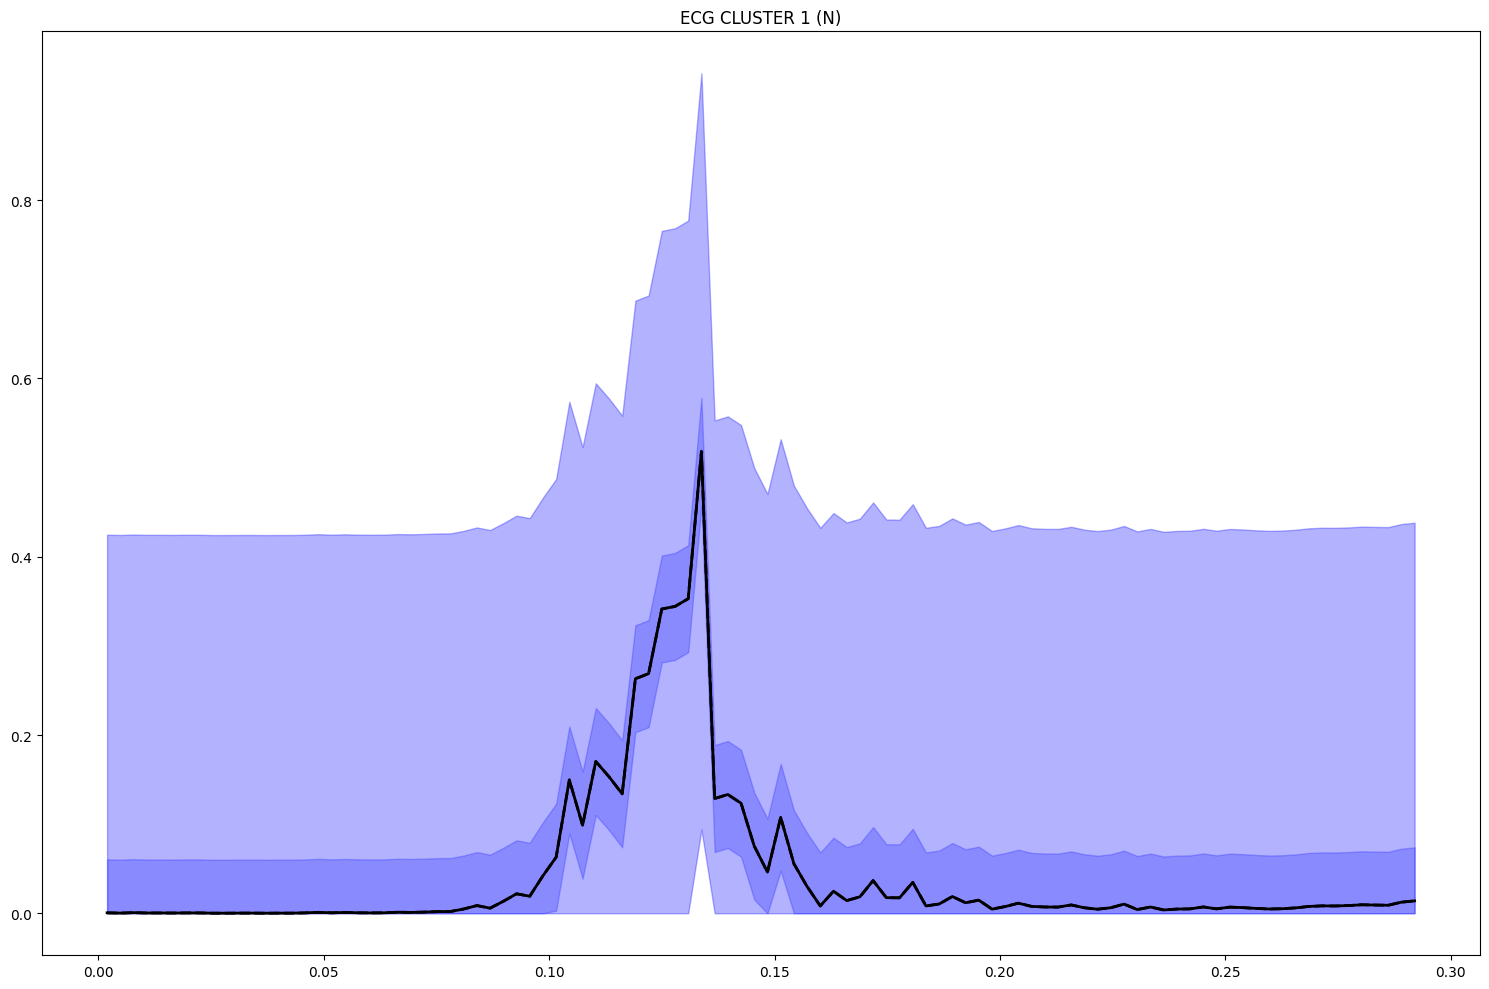

In [17]:
print("Kernel estimated:", sw_gp.gpmodels[0][0].gp.kernel)

#Generate artificial labels to plot using util_plots.
from hdpgpc.util_plots import print_results, plot_models_plotly
labels = np.array(['N'] * data.shape[0])
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, labels, main_model, N_0=0, lead=0, step=freq[1]-freq[0], plot_latent=True, ticks=True)

Kernel estimated: 1.65**2 * RBF(length_scale=0.00445) + WhiteKernel(noise_level=2.34e-08)
Model 1 : MainModel: N : [N-1]
Model 2  : []
Classification error:  0.0 / 1 -- 0.0


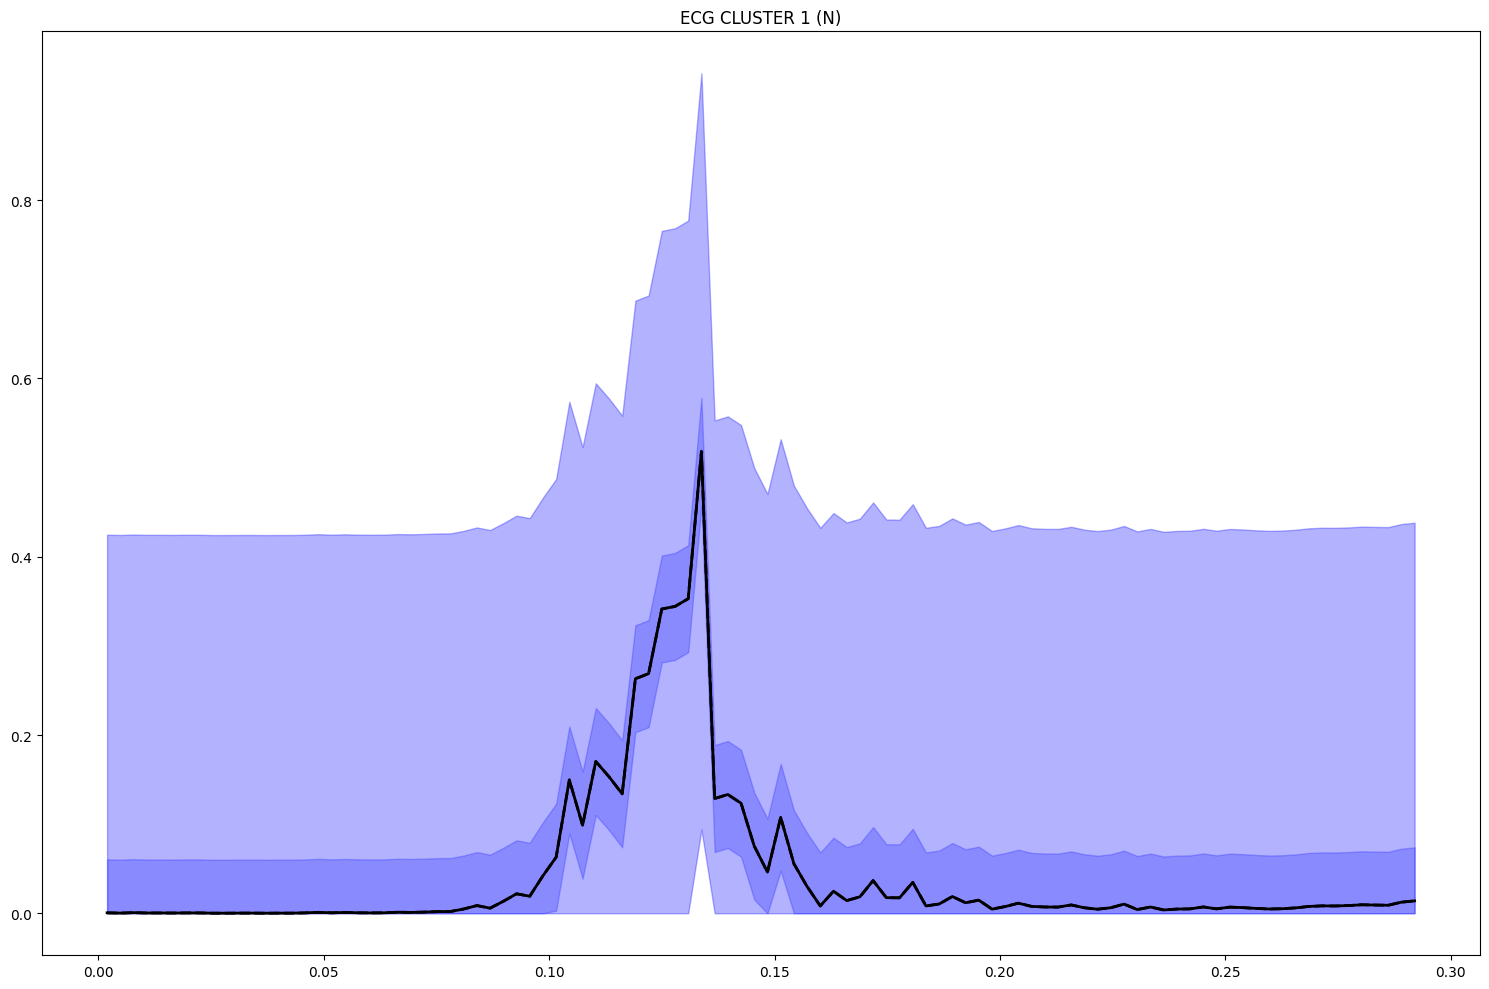

In [18]:
print("Kernel estimated:", sw_gp.gpmodels[0][0].gp.kernel)

#Generate artificial labels to plot using util_plots.
from hdpgpc.util_plots import print_results, plot_models_plotly
labels = np.array(['N'] * data.shape[0])
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, labels, main_model, N_0=0, lead=0, step=freq[1]-freq[0], plot_latent=True, ticks=True)

Model 1 : MainModel: N : [N-2322]
Model 2 : MainModel: N : [N-287]
Model 3 : MainModel: N : [N-183]
Model 4 : MainModel: N : [N-177]
Model 5 : MainModel: N : [N-136]
Model 6 : MainModel: N : [N-117]
Model 7 : MainModel: N : [N-94]
Model 8 : MainModel: N : [N-18]
Model 9 : MainModel: N : [N-15]
Model 10 : MainModel: N : [N-15]
Model 11 : MainModel: N : [N-8]
Model 12 : MainModel: N : [N-5]
Model 13 : MainModel: N : [N-2]
Classification error:  0.0 / 3379 -- 0.0


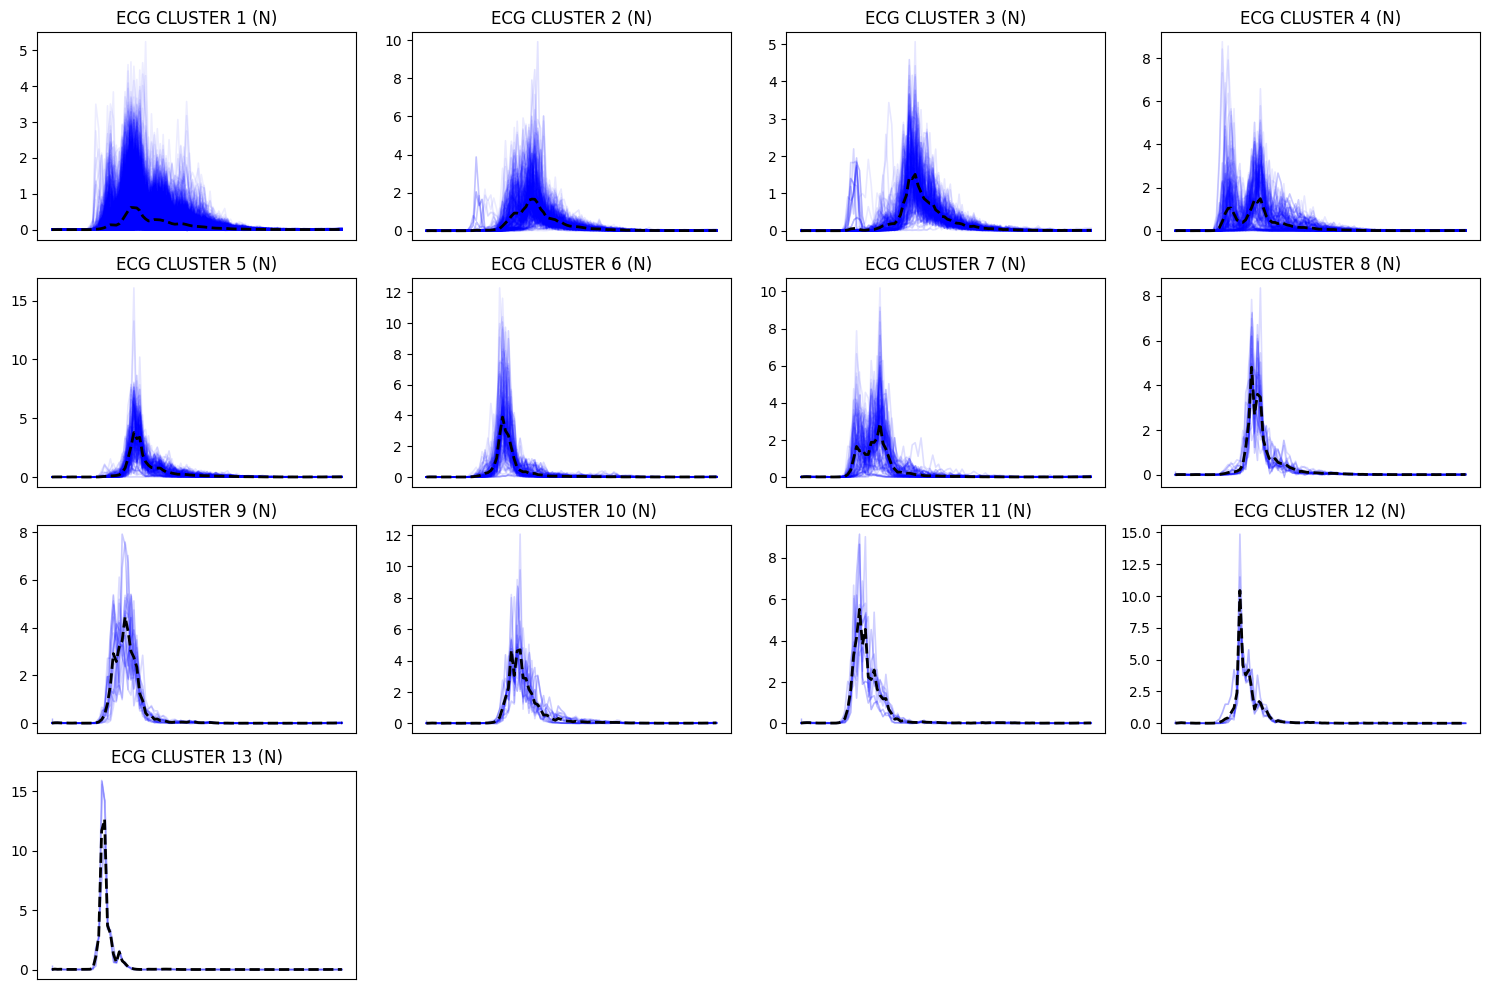

In [32]:
from hdpgpc.util_plots import print_results, plot_models_plotly

main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=0.5, plot_latent=True)

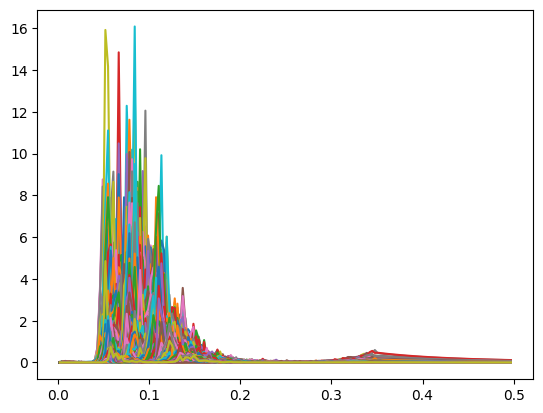

In [20]:
data_ = data[:,:,[0]]
plt.plot(freq, data_[:,:,0].T)
plt.show()

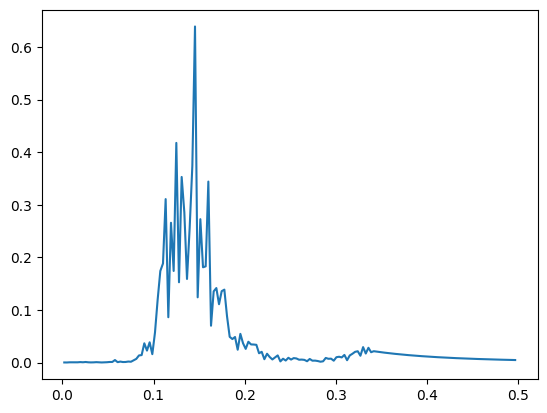

In [21]:
data_ = data[:,:,[0]]
plt.plot(freq, data_[2010,:,0].T)
plt.savefig("/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/data2010_0.png")

In [22]:
sw_gp = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=False, max_models=100, inducing_points=inducing_points, reestimate_initial_params=False,
                          n_explore_steps=15, free_deg_MNIV=10)

num_samples = data.shape[0]
#logdata = np.log(data + 1e-6)
x_trains = np.array([x_train] * num_samples)
sw_gp.include_batch(x_trains, data[:,0:100,[0]])

Group responsability estimated: [3379    0]
---Kernel estimated---
1.65**2 * RBF(length_scale=0.00445) + WhiteKernel(noise_level=2.34e-08)

-----------Lead 1-----------
Step 1/15- Trying to divide: 0 with beat 1158
---Kernel estimated---
2.04**2 * RBF(length_scale=0.00218) + WhiteKernel(noise_level=2.37e-08)

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------
Current resp: tensor([3.3770e+03, 2.0000e+00])
ELBO_reduction: 0.0

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------
Current resp: tensor([3.3770e+03, 2.0000e+00])
ELBO_reduction: 0.0
Sum resp_temp: tensor([3.3770e+03, 2.0000e+00])
Q_bas: tensor(-120006.3323), Q_lat: tensor(-8551412.9288), Elbo_bas: tensor([-8580386.9556])
Q_bas_post: tensor(-119878.6209), Q_lat: tensor(-8442401.8932), Elbo_post: tensor([-8456935.0263])
Chosen to divide: 0 with beat 1158
First resp: tensor([3.3770e+03, 2.0000e+00])

-----------Lead 1-----------

   ------

Model 1 : MainModel: N : [N-2322]
Model 2 : MainModel: N : [N-287]
Model 3 : MainModel: N : [N-183]
Model 4 : MainModel: N : [N-177]
Model 5 : MainModel: N : [N-136]
Model 6 : MainModel: N : [N-117]
Model 7 : MainModel: N : [N-94]
Model 8 : MainModel: N : [N-18]
Model 9 : MainModel: N : [N-15]
Model 10 : MainModel: N : [N-15]
Model 11 : MainModel: N : [N-8]
Model 12 : MainModel: N : [N-5]
Model 13 : MainModel: N : [N-2]
Classification error:  0.0 / 3379 -- 0.0


TypeError: max() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis


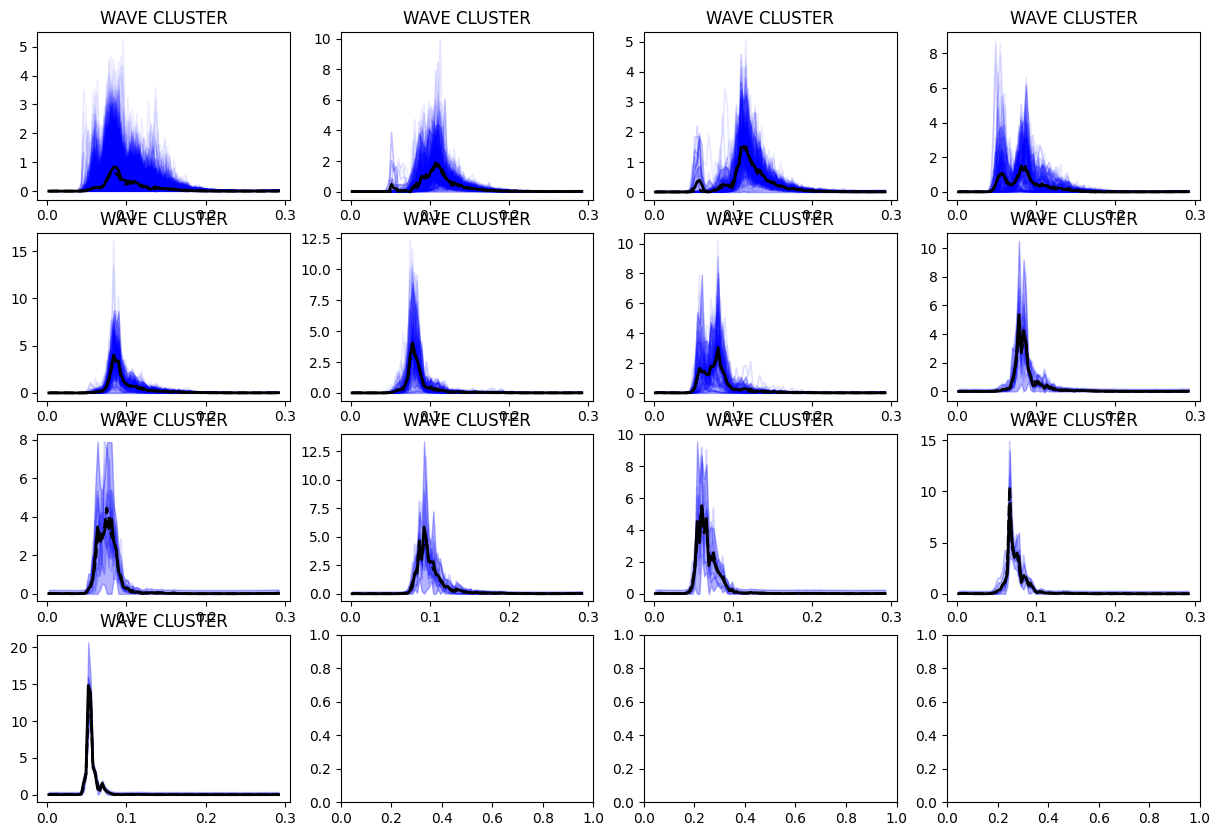

In [33]:
labels = np.array(['N'] * 6500)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
up.plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=(freq[1]-freq[0])/1,
                   plot_latent=False, title='WAVE CLUSTER',ticks=True, yscale=True, save="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/clusters_6500_10to70.png")

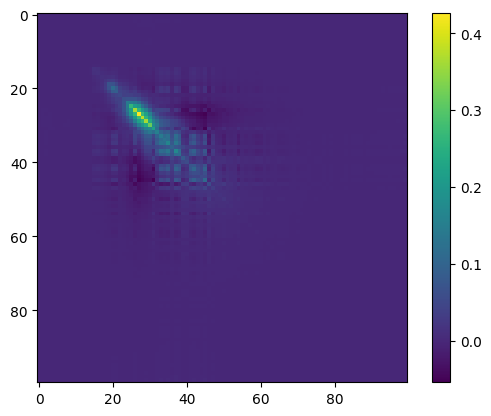

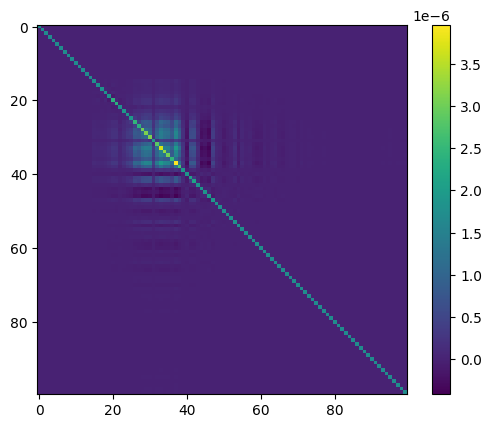

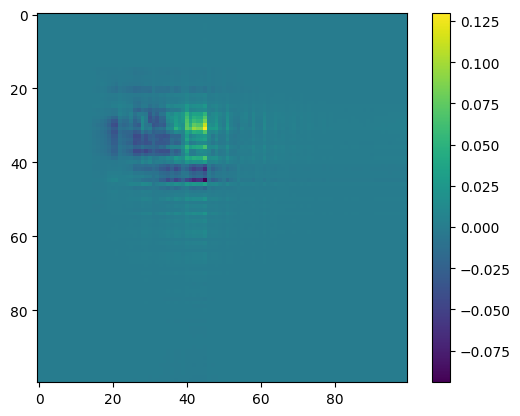

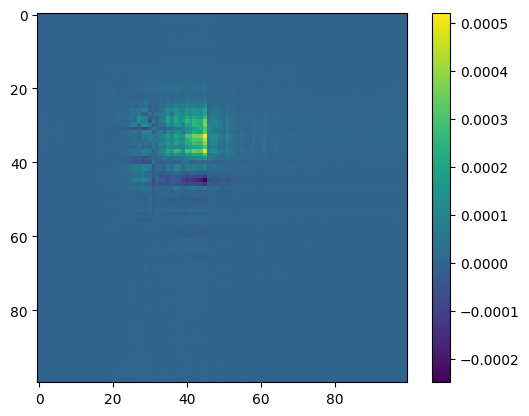

In [24]:
plt.figure()
plt.imshow(sw_gp.gpmodels[0][0].Sigma[-1])
plt.colorbar()
plt.savefig("/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/Sigma_6500_10to70.png")
plt.figure()
plt.imshow(sw_gp.gpmodels[0][0].Gamma[-1])
plt.colorbar()
plt.savefig("/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/Gamma_6500_10to70.png")
plt.figure()
plt.imshow(sw_gp.gpmodels[0][0].C[-1]-torch.eye(sw_gp.gpmodels[0][0].C[-1].shape[0]))
plt.colorbar()
plt.savefig("/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/C_6500_10to70.png")
plt.figure()
plt.imshow(sw_gp.gpmodels[0][0].A[-1]-torch.eye(sw_gp.gpmodels[0][0].A[-1].shape[0]))
plt.colorbar()
plt.savefig("/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/A_6500_10to70.png")


IndexError: list index out of range

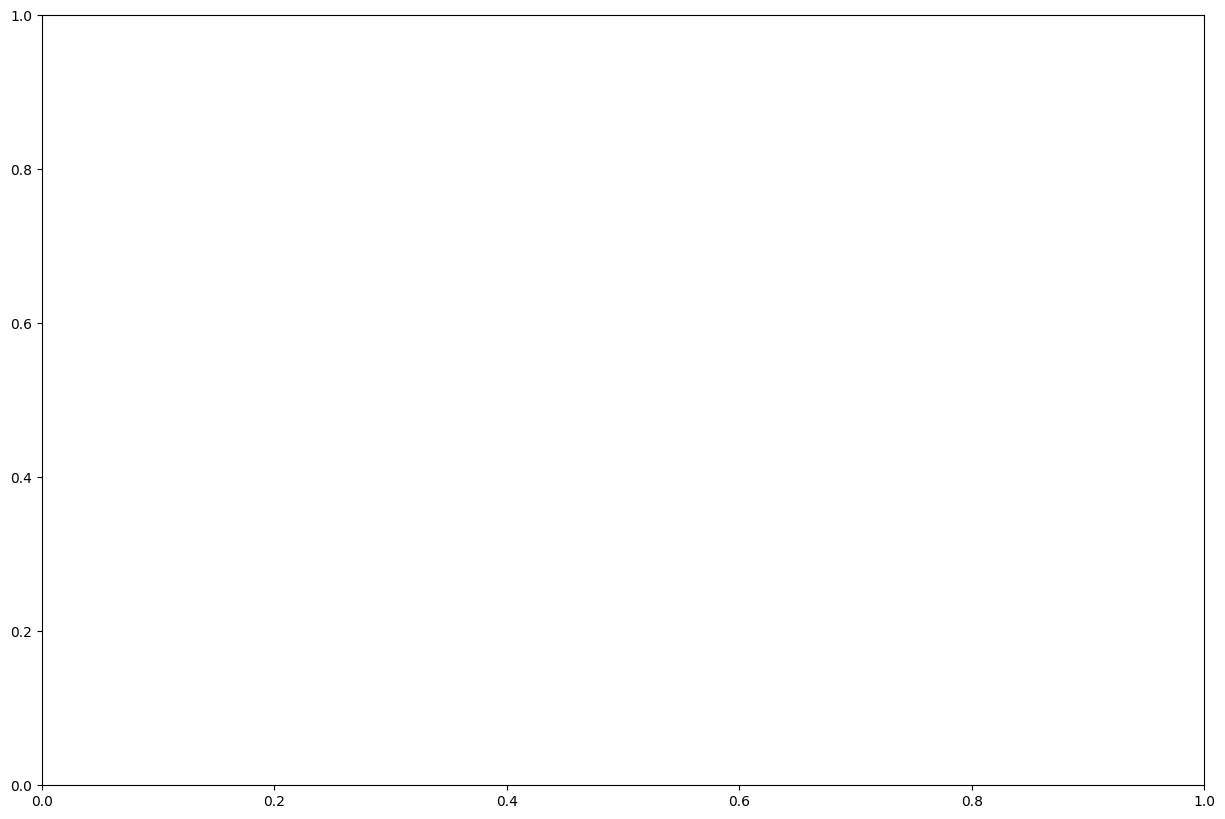

In [25]:
up.plot_models_plotly(sw_gp, [17], main_model, labels, N_0=0, lead=0, step=(freq[1]-freq[0])/1,
                   plot_latent=False, title='WAVE CLUSTER',ticks=True, save="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/cluster_6500_10to70.png")

---

# Gráfica distribución por meses y clusters

In [26]:
from datetime import datetime, timedelta

# Fechas de inicio y finalización
start_date = datetime(2019, 6, 25)
end_date = datetime(2021, 2, 12)

# Lista para guardar las fechas en formato cadena
dates = []

# Generar fechas y horas
current_date = start_date
while current_date <= end_date:
    for hour in range(24):  # 24 horas por día
        formatted_date = current_date.replace(hour=hour).strftime("%Y-%m-%d")
        dates.append(formatted_date)
    current_date += timedelta(days=1)

print(f"Total de elementos: {len(dates)}")

Total de elementos: 14376


In [27]:
data_2 = data.reshape(14376, 171)
data_2 = pd.DataFrame(data_2)
data_2['fecha'] = dates

ValueError: cannot reshape array of size 574430 into shape (14376,171)

In [ ]:
labels = np.array(['N'] * 2500)
num_clusters = len(sw_gp.selected_gpmodels())
filas_datos = []

for K in range(num_clusters):
    y_train = sw_gp.gpmodels[0][K].y_train
    M = len(y_train)  # Máximo valor de L para este K
    for L in range(M):
        tensor_values = y_train[L].numpy().flatten()  # Convierte el tensor a una lista plana
        row = list(tensor_values) + [K]  # Añade K al final de la fila
        filas_datos.append(row)

In [ ]:
# Crea un dataframe
df = pd.DataFrame(filas_datos)

# Renombra las columnas
num_tensor_values = len(filas_datos[0]) - 1  # Número de valores en el tensor
df.columns = [i for i in range(num_tensor_values)] + ["cluster"]

In [ ]:
key_columns = df.columns[:171]

# Realiza el join utilizando las columnas clave
result_df = pd.merge(data_2, df, on=key_columns.tolist(), how="inner")  # 'inner' para intersección, ajusta según necesidad

In [ ]:
result_df

In [ ]:
result_df['fecha'] = pd.to_datetime(result_df['fecha'])
result_df['mes'] = result_df['fecha'].dt.month
result_df['dia'] = result_df['fecha'].dt.dayofyear

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(result_df['dia'], result_df['cluster'], alpha=0.7)



# Ajusta las etiquetas para que coincidan con los días del año
plt.title('Scatter Plot: Día del Año vs Cluster')
plt.xlabel('Mes')
plt.ylabel('Cluster')

# Agrega las etiquetas de los meses
plt.xticks(
    ticks=[15 + i * 30 for i in range(5, 8)],  # Aprox. posición para los meses
    labels=['Jun', 'Jul', 'Aug']
)

plt.show()